In [1]:
#### para instalar skopt #######
#!pip install scikit-optimize


In [2]:
# para ignorar warnings (no funciona como esperaba, hay que darle una vuelta de rosca mas)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
from ipynb.fs.full.pipeline_class import Text_preprocessor, Text_extrafeatures, func_dict, TfidfEmbeddingVectorizer, CollocationGenerator
#from pipeline_class import Text_preprocessor, Text_extrafeatures, func_dict, TfidfEmbeddingVectorizer, CollocationGenerator
from ipynb.fs.defs.preprocess import lemmatizer, remove_stopwords, sentence_tokenizer
#from preprocess import lemmatizer, remove_stopwords, sentence_tokenizer

C:\Users\juan.roman\AppData\Local\Programs\Python\Python37\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import pickle
import gzip
import copy
import time

In [5]:
#Librerias
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


In [6]:
#Optimizador bayesiano
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [7]:
# Classifiers
import lightgbm as lgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as  sns
from sklearn.metrics import roc_curve, auc, confusion_matrix , roc_auc_score,accuracy_score , recall_score, f1_score,precision_score
from Model_Evaluation_functions import plot_score_progession,plot_roc_auc,plot_prob_density, plot_confusion_matrix, fit_clf

#### --------------------------------------------------------------------------------- 

In [9]:
#### LOAD DATASET CON PICKLE #######
pickle_file = open('./data/dataframe_preproc.pkl','rb')

df = pickle.load(pickle_file)
df = df.sample(frac=1, random_state=12).copy() # mezclo los datos para que los subsambling sean aleatorios
pickle_file.close()

df

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,principal_nconst_list,principal_nconst_count,directors,writers,directors_count,writers_count,averageRating,numVotes,rating,raw_text,preproc_text
tconst,,,,,,,,,,,,,,,,,,,
tt3171176,movie,Painkillers,Painkillers,0.0,2015.0,NaN,102.0,"Action,Sci-Fi,Thriller","nm0220406,nm0671886,nm2788229,nm0272173,nm1570...",10.0,nm0936044,"nm5929911,nm0740427,nm0936044",1.0,3.0,4.1,498.0,Wait for Netflix,female soldier: towards that exit! cafferty: h...,female soldier towards exit cafferty hey dont ...
tt3202670,movie,96 heures,96 heures,0.0,2014.0,NaN,96.0,Thriller,"nm0702467,nm0487254,nm0034390,nm0856500,nm0175...",10.0,nm0774420,"nm0584770,nm0410707,nm0109730",1.0,3.0,5.5,279.0,Wait for Netflix,,
tt2889050,movie,La mossa del pinguino,La mossa del pinguino,0.0,2013.0,NaN,90.0,Comedy,"nm0230510,nm0502412,nm0578633,nm0266890,nm0268...",10.0,nm0024580,"nm2385292,nm0024580,nm5658465,nm0502412,nm5926435",1.0,5.0,5.9,509.0,Wait for Netflix,they are highly specialized and social animals...,highly_specialized social animal hydrodynamic_...
tt6493644,movie,Birds Without Names,Kanojo ga sono na wo shiranai toritachi,0.0,2017.0,NaN,123.0,"Drama,Mystery","nm0847570,nm0008369,nm2344050,nm2797973,nm1066...",10.0,nm3629099,nm8616760,1.0,1.0,6.4,156.0,Wait for Netflix,﻿ you really have to do something. i have aske...,really something ask since month_ago third tim...
tt3635300,movie,Girls for Sale,Girls for Sale,0.0,2016.0,NaN,87.0,Drama,"nm3615754,nm5448949,nm6394971,nm2733090,nm6394...",10.0,nm3324534,"nm6394985,nm7359828,nm3324534,nm6394986,nm6394987",1.0,5.0,3.3,32.0,Wait for Netflix,"- all right, lets see. . move the light, mate....",all_right let see move light mate all_right th...
tt4844348,movie,Spear,Spear,0.0,2015.0,NaN,84.0,Drama,"nm0633354,nm0669853,nm3638200,nm3973384,nm7444...",10.0,nm2465962,"nm0542493,nm2465962",1.0,2.0,6.7,64.0,Wait for Netflix,,
tt5582876,movie,In the Name of Ben Hur,In the Name of Ben Hur,0.0,2016.0,NaN,89.0,Action,"nm2106033,nm5956650,nm1345685,nm2481125,nm5557...",10.0,nm0040630,nm0040630,1.0,1.0,2.7,709.0,Wait for Netflix,1 in the name of ben-hur subrip: pix this is e...,name ben-hur_subrip pix exactly whats_wrong to...
tt5544384,movie,Sword Art Online: The Movie - Ordinal Scale,Gekijo-ban Sword Art Online: Ordinal Scale,0.0,2017.0,NaN,119.0,"Action,Adventure,Animation","nm4441200,nm4303311,nm2955927,nm2821488,nm2971...",10.0,nm2423816,"nm2423816,nm4986613,nm0902135",1.0,3.0,7.4,2933.0,Buy cinema ticket,https://t.me/rickychannel its a shame you cant...,http //t.me/rickychannel shame cant see star a...
tt5797820,movie,Real: O Plano por Trás da História,Real: O Plano por Trás da História,0.0,2017.0,NaN,96.0,"Drama,History","nm0251896,nm3932366,nm2142737,nm0996588,nm2131...",10.0,nm2709019,nm8066791,1.0,1.0,6.1,559.0,Wait for Netflix,this movie is a fiction based on real facts. s...,movie fiction base real fact character dialogu...


In [10]:
#PRECONDICION, LOS DATOS SE OBTIENEN DE dataframe.pkl QUE TIENE LOS SUBTITULOS YA LIMPIOS 
#Creacion de Pipe de preprocesamiento

#%%time
LSA_K = 300 # cantidad de "topicos" LSA
LDA_TOPICS = 300 # cantidad de topicos LDA

tf_idf_vect = TfidfVectorizer(max_df=0.9, min_df=0.1 , stop_words="english" )
tf_idf_transf = TfidfTransformer() #trasnforma el count_vectorizer en tfidf, unsando el transformador, me evito volver a calcularlo
count_vect = CountVectorizer(max_df=0.9 , min_df=0.1 , stop_words="english")
text_preproc = Text_preprocessor(lemmatizer) # la funcion preprocess hace la lematización, limpia stopwords y demás
new_features = Text_extrafeatures(func_dict) # func_dict es para alacenar funciones que crean nuevos features
SVD = TruncatedSVD(n_components=LSA_K, algorithm = 'arpack')
lda = LatentDirichletAllocation(n_components=LDA_TOPICS, max_iter=100, learning_method="online", n_jobs=-1)
w2v = TfidfEmbeddingVectorizer(tf_idf_vect)
lemma = Text_preprocessor(lemmatizer)
sent_token = Text_preprocessor(sentence_tokenizer)
collocations = CollocationGenerator()
sw = Text_preprocessor(remove_stopwords)




text_preproc = Pipeline([("lemmatizer",lemma), 
                             ("sent_token",sent_token),
                             ("collocations",collocations),
                             ("sw",sw)
                            ])

lsa_tfidf_pipe = Pipeline([("tfidf_transf", tf_idf_transf),
                            ("lsa",SVD)
                           ])

topic_pipe = Pipeline([
                        ("tf_vec", count_vect),
                        ("topic_features",FeatureUnion([
                                                        ("lda",lda),
                                                        ("lsa_tfidf_pipe",lsa_tfidf_pipe),
                                                        ]))
                    ])


new_features_pipe = Pipeline([
                                ("new_features",new_features),
                                ("std_scaler",StandardScaler())
                           ])


dataset_pipeline = Pipeline([("text_preproc", text_preproc),
                             ("text_features",FeatureUnion([
                                                            ("new_features",new_features_pipe),
                                                            ("topics",topic_pipe),
                                                            #("embedding",w2v)
                                                            ]))
                            
    
                            ])


lgb_clf = lgb.LGBMClassifier(max_depth=5, n_estimators=10,n_jobs=-1, feature_fraction=0.7,eval_metric="auc")
clf_pipeline = Pipeline([("dataset",dataset_pipeline),("clf", lgb_clf)])

###### ----------------------------------------------------------------------------------------- 

In [11]:
# Train, Valid, Test split


FEATURE_NAME = "raw_text" 
CLASS_NAME = "rating"


X = df[FEATURE_NAME]
y = df[CLASS_NAME].isin(["Buy cinema ticket"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y )
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=5000, random_state=42, stratify=y_train)

print("X_train:%s\ty_train:%s\tPositive prop:%.3f"%(X_train.shape,y_train.shape,y_train.sum()/len(y_train)))
print("X_valid:%s\ty_valid:%s\tPositive prop:%.3f"%(X_valid.shape,y_valid.shape,y_valid.sum()/len(y_valid)))
print("X_test:%s\ty_test:%s\tPositive prop:%.3f"%(X_test.shape,y_test.shape,y_test.sum()/len(y_test)))


X_train:(5000,)	y_train:(5000,)	Positive prop:0.205
X_valid:(1400,)	y_valid:(1400,)	Positive prop:0.205
X_test:(1600,)	y_test:(1600,)	Positive prop:0.204


C:\Users\juan.roman\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Evaluación de Modelos

In [37]:
#### diccionario de modelos
mod_dict ={
"mod_11":{"plot_name":"mod_11",
          "dataset_pipeline": dataset_pipeline,
          "dataset_pipeline_params": {'text_features__topics__topic_features__lsa_tfidf_pipe__lsa__n_components': 50,
                                    'text_features__topics__topic_features__lda__n_components': 300, 
                                    'text_features__topics__tf_vec__min_df': 0.3,
                                    'text_features__topics__tf_vec__max_df': 0.9,  
                                    },
          "clf" : lgb.LGBMClassifier(max_depth=5, n_estimators=2000,n_jobs=-1,eval_metric="auc",feature_fraction=0.7),
          "clf_params":{'reg_lambda': 0.0, 
                        'bagging_freq': 10, 
                        'max_depth': 12, 
                        'learning_rate': 0.01, 
                        'min_child_samples': 100, 
                        'feature_fraction': 0.7, 
                        'bagging_fraction': 0.7, 
                        'reg_alpha': 1.0, 
                        },
         }}

mod_dict["mod_22"]= {"plot_name":"Mod 22",
                      "dataset_pipeline": dataset_pipeline,
                      "dataset_pipeline_params": {'text_features__topics__topic_features__lsa_tfidf_pipe__lsa__n_components': 12,
                                                'text_features__topics__topic_features__lda__n_components': 374, 
                                                'text_features__topics__tf_vec__min_df': 0.197551972,
                                                'text_features__topics__tf_vec__max_df': 0.979102298,  
                                                },
                      "clf" : lgb.LGBMClassifier(max_depth=5, n_estimators=2000,n_jobs=-1,eval_metric="auc",feature_fraction=0.7),
                      "clf_params":{'reg_lambda': 4.743940522, 
                                    'bagging_freq': 32, 
                                    'max_depth': 14, 
                                    'learning_rate': 0.0074748, 
                                    'min_child_samples': 72, 
                                    'feature_fraction': 0.657068772, 
                                    'bagging_fraction': 0.612837533, 
                                    'reg_alpha': 8.682801622, 
                                    },
                     }

mod_dict["mod_33"]= {"plot_name":"Mod 33",
                      "dataset_pipeline": dataset_pipeline,
                      "dataset_pipeline_params": {'text_features__topics__topic_features__lsa_tfidf_pipe__lsa__n_components': 100,
                                                'text_features__topics__topic_features__lda__n_components': 200, 
                                                'text_features__topics__tf_vec__min_df': 0.123189138,
                                                'text_features__topics__tf_vec__max_df': 0.99,  
                                                },
                      "clf" : lgb.LGBMClassifier(max_depth=5, n_estimators=2000,n_jobs=-1,eval_metric="auc",feature_fraction=0.7),
                      "clf_params":{'reg_lambda': 0, 
                                    'bagging_freq': 50, 
                                    'max_depth': 10, 
                                    'learning_rate': 0.01, 
                                    'min_child_samples': 100, 
                                    'feature_fraction': 0.2, 
                                    'bagging_fraction': 0.6, 
                                    'reg_alpha': 10, 
                                    },
                     }

mod_dict["mod_36"]= {"plot_name":"Mod 36",
                      "dataset_pipeline": dataset_pipeline,
                      "dataset_pipeline_params": {'text_features__topics__topic_features__lsa_tfidf_pipe__lsa__n_components': 65,
                                                'text_features__topics__topic_features__lda__n_components': 400, 
                                                'text_features__topics__tf_vec__min_df': 0.3,
                                                'text_features__topics__tf_vec__max_df': 0.99,  
                                                },
                      "clf" : lgb.LGBMClassifier(max_depth=5, n_estimators=2000,n_jobs=-1,eval_metric="auc",feature_fraction=0.7),
                      "clf_params":{'reg_lambda': 0, 
                                    'bagging_freq': 10, 
                                    'max_depth': 15, 
                                    'learning_rate': 0.01, 
                                    'min_child_samples': 20, 
                                    'feature_fraction': 0.2, 
                                    'bagging_fraction': 0.6, 
                                    'reg_alpha': 10, 
                                    },
                     }

mod_dict["mod_34"]= {"plot_name":"Mod 34",
                      "dataset_pipeline": dataset_pipeline,
                      "dataset_pipeline_params": {'text_features__topics__topic_features__lsa_tfidf_pipe__lsa__n_components': 100,
                                                'text_features__topics__topic_features__lda__n_components': 400, 
                                                'text_features__topics__tf_vec__min_df': 0.01,
                                                'text_features__topics__tf_vec__max_df': 0.99,  
                                                },
                      "clf" : lgb.LGBMClassifier(max_depth=5, n_estimators=2000,n_jobs=-1,eval_metric="auc",feature_fraction=0.7),
                      "clf_params":{'reg_lambda': 1.906908061, 
                                    'bagging_freq': 10, 
                                    'max_depth': 15, 
                                    'learning_rate': 0.006628108, 
                                    'min_child_samples': 100, 
                                    'feature_fraction': 0.7, 
                                    'bagging_fraction': 0.6, 
                                    'reg_alpha': 0, 
                                    },
                     }

In [38]:
%%time

for key in ["mod_22","mod_33","mod_36","mod_34"]:
    print("#########\n Comienzo modelado %s"%(key))
    t0 = time.time()
    #Entrenamiento
    result_dict[key] = fit_clf(mod_dict.get(key),X_train,y_train,eval_set=(X_valid,y_valid),early_stoping=100,extra_clf_params={"eval_metric":"auc"})
    print("Modelo: %s\tTiempo de entrenamiento:%.2f min"%(key,(time.time()-t0)/60.0))
    #Predicciones
    clf = result_dict[key].get("clf_fitted")
    features_pipe = result_dict[key].get("feat_pipe_fitted")
    X_valid_prep = features_pipe.transform(X_valid)
    X_test_prep = features_pipe.transform(X_test)
    X_train_prep = features_pipe.transform(X_train)
    result_dict[key]["y_test_proba"] = clf.predict_proba(X_test_prep, num_iteration=clf.best_iteration_)
    result_dict[key]["y_valid_proba"] = clf.predict_proba(X_valid_prep, num_iteration=clf.best_iteration_)
    result_dict[key]["y_train_proba"] = clf.predict_proba(X_train_prep, num_iteration=clf.best_iteration_)
    print("Best Score (AUC): %.4f\tIteración #:%d"%(clf.best_score_['valid_0']['auc'] , clf.best_iteration_))
    
    #Guardo resultados
    test_results_df = DataFrame(result_dict[key]["y_test_proba"], columns=["FALSE_proba","TRUE_proba"], index=y_test.index)
    test_results_df["y_real"] = y_test
    test_results_df.to_excel("./resultados/%s_test_result.xlsx"%(key))
    train_results_df = DataFrame(result_dict[key]["y_train_proba"], columns=["FALSE_proba","TRUE_proba"], index=y_train.index)
    train_results_df["y_real"] = y_train
    train_results_df.to_excel("./resultados/%s_train_result.xlsx"%(key))
    valid_results_df = DataFrame(result_dict[key]["y_valid_proba"], columns=["FALSE_proba","TRUE_proba"], index=y_valid.index)
    valid_results_df["y_real"] = y_valid
    valid_results_df.to_excel("./resultados/%s_valid_result.xlsx"%(key))
    print("Finalizado")

#########
 Comienzo modelado mod_22
[1]	valid_0's auc: 0.689597
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.728118
[3]	valid_0's auc: 0.740611
[4]	valid_0's auc: 0.745676
[5]	valid_0's auc: 0.74894
[6]	valid_0's auc: 0.746011
[7]	valid_0's auc: 0.744122
[8]	valid_0's auc: 0.749224
[9]	valid_0's auc: 0.749401
[10]	valid_0's auc: 0.750696
[11]	valid_0's auc: 0.74978
[12]	valid_0's auc: 0.748612
[13]	valid_0's auc: 0.747337
[14]	valid_0's auc: 0.746239
[15]	valid_0's auc: 0.748165
[16]	valid_0's auc: 0.749822
[17]	valid_0's auc: 0.750513
[18]	valid_0's auc: 0.750599
[19]	valid_0's auc: 0.750675
[20]	valid_0's auc: 0.750804
[21]	valid_0's auc: 0.749739
[22]	valid_0's auc: 0.749905
[23]	valid_0's auc: 0.748922
[24]	valid_0's auc: 0.750257
[25]	valid_0's auc: 0.751024
[26]	valid_0's auc: 0.750862
[27]	valid_0's auc: 0.750405
[28]	valid_0's auc: 0.749475
[29]	valid_0's auc: 0.750525
[30]	valid_0's auc: 0.751461
[31]	valid_0's auc: 0.752358
[32]	valid_0'

[283]	valid_0's auc: 0.777257
[284]	valid_0's auc: 0.777235
[285]	valid_0's auc: 0.777307
[286]	valid_0's auc: 0.777376
[287]	valid_0's auc: 0.777442
[288]	valid_0's auc: 0.777511
[289]	valid_0's auc: 0.777626
[290]	valid_0's auc: 0.777605
[291]	valid_0's auc: 0.777702
[292]	valid_0's auc: 0.778243
[293]	valid_0's auc: 0.778115
[294]	valid_0's auc: 0.778284
[295]	valid_0's auc: 0.778387
[296]	valid_0's auc: 0.778628
[297]	valid_0's auc: 0.778591
[298]	valid_0's auc: 0.778876
[299]	valid_0's auc: 0.779041
[300]	valid_0's auc: 0.779129
[301]	valid_0's auc: 0.779151
[302]	valid_0's auc: 0.779057
[303]	valid_0's auc: 0.77896
[304]	valid_0's auc: 0.778894
[305]	valid_0's auc: 0.779038
[306]	valid_0's auc: 0.779026
[307]	valid_0's auc: 0.779067
[308]	valid_0's auc: 0.779148
[309]	valid_0's auc: 0.779236
[310]	valid_0's auc: 0.779201
[311]	valid_0's auc: 0.779179
[312]	valid_0's auc: 0.779257
[313]	valid_0's auc: 0.779283
[314]	valid_0's auc: 0.779248
[315]	valid_0's auc: 0.779151
[316]	valid

[571]	valid_0's auc: 0.785634
[572]	valid_0's auc: 0.785669
[573]	valid_0's auc: 0.785728
[574]	valid_0's auc: 0.785888
[575]	valid_0's auc: 0.786035
[576]	valid_0's auc: 0.786026
[577]	valid_0's auc: 0.785985
[578]	valid_0's auc: 0.786063
[579]	valid_0's auc: 0.786026
[580]	valid_0's auc: 0.786151
[581]	valid_0's auc: 0.786063
[582]	valid_0's auc: 0.78607
[583]	valid_0's auc: 0.786054
[584]	valid_0's auc: 0.786026
[585]	valid_0's auc: 0.785973
[586]	valid_0's auc: 0.786001
[587]	valid_0's auc: 0.785985
[588]	valid_0's auc: 0.786095
[589]	valid_0's auc: 0.78602
[590]	valid_0's auc: 0.786132
[591]	valid_0's auc: 0.786063
[592]	valid_0's auc: 0.786082
[593]	valid_0's auc: 0.786085
[594]	valid_0's auc: 0.786117
[595]	valid_0's auc: 0.78607
[596]	valid_0's auc: 0.786023
[597]	valid_0's auc: 0.785835
[598]	valid_0's auc: 0.785819
[599]	valid_0's auc: 0.785735
[600]	valid_0's auc: 0.785772
[601]	valid_0's auc: 0.785741
[602]	valid_0's auc: 0.785753
[603]	valid_0's auc: 0.785547
[604]	valid_0

[846]	valid_0's auc: 0.78874
[847]	valid_0's auc: 0.788774
[848]	valid_0's auc: 0.78889
[849]	valid_0's auc: 0.788972
[850]	valid_0's auc: 0.789009
[851]	valid_0's auc: 0.788959
[852]	valid_0's auc: 0.78895
[853]	valid_0's auc: 0.789213
[854]	valid_0's auc: 0.789025
[855]	valid_0's auc: 0.789166
[856]	valid_0's auc: 0.789178
[857]	valid_0's auc: 0.78926
[858]	valid_0's auc: 0.789282
[859]	valid_0's auc: 0.789266
[860]	valid_0's auc: 0.789072
[861]	valid_0's auc: 0.789125
[862]	valid_0's auc: 0.789119
[863]	valid_0's auc: 0.789153
[864]	valid_0's auc: 0.789241
[865]	valid_0's auc: 0.789188
[866]	valid_0's auc: 0.789125
[867]	valid_0's auc: 0.789172
[868]	valid_0's auc: 0.789203
[869]	valid_0's auc: 0.789244
[870]	valid_0's auc: 0.789266
[871]	valid_0's auc: 0.789247
[872]	valid_0's auc: 0.789225
[873]	valid_0's auc: 0.789172
[874]	valid_0's auc: 0.789263
[875]	valid_0's auc: 0.789178
[876]	valid_0's auc: 0.789297
[877]	valid_0's auc: 0.789357
[878]	valid_0's auc: 0.789235
[879]	valid_0'

[144]	valid_0's auc: 0.753656
[145]	valid_0's auc: 0.753524
[146]	valid_0's auc: 0.753236
[147]	valid_0's auc: 0.753336
[148]	valid_0's auc: 0.75287
[149]	valid_0's auc: 0.753133
[150]	valid_0's auc: 0.753311
[151]	valid_0's auc: 0.75323
[152]	valid_0's auc: 0.753452
[153]	valid_0's auc: 0.753534
[154]	valid_0's auc: 0.753768
[155]	valid_0's auc: 0.753584
[156]	valid_0's auc: 0.753731
[157]	valid_0's auc: 0.754216
[158]	valid_0's auc: 0.754673
[159]	valid_0's auc: 0.754858
[160]	valid_0's auc: 0.754798
[161]	valid_0's auc: 0.755033
[162]	valid_0's auc: 0.754827
[163]	valid_0's auc: 0.755018
[164]	valid_0's auc: 0.755014
[165]	valid_0's auc: 0.755399
[166]	valid_0's auc: 0.75524
[167]	valid_0's auc: 0.755687
[168]	valid_0's auc: 0.755775
[169]	valid_0's auc: 0.755572
[170]	valid_0's auc: 0.755528
[171]	valid_0's auc: 0.755359
[172]	valid_0's auc: 0.755221
[173]	valid_0's auc: 0.755162
[174]	valid_0's auc: 0.755271
[175]	valid_0's auc: 0.755647
[176]	valid_0's auc: 0.755694
[177]	valid_0

[237]	valid_0's auc: 0.767515
[238]	valid_0's auc: 0.767324
[239]	valid_0's auc: 0.767499
[240]	valid_0's auc: 0.767568
[241]	valid_0's auc: 0.767743
[242]	valid_0's auc: 0.767994
[243]	valid_0's auc: 0.767731
[244]	valid_0's auc: 0.767865
[245]	valid_0's auc: 0.767969
[246]	valid_0's auc: 0.768116
[247]	valid_0's auc: 0.768185
[248]	valid_0's auc: 0.768347
[249]	valid_0's auc: 0.768501
[250]	valid_0's auc: 0.768493
[251]	valid_0's auc: 0.76879
[252]	valid_0's auc: 0.76864
[253]	valid_0's auc: 0.768797
[254]	valid_0's auc: 0.768731
[255]	valid_0's auc: 0.769207
[256]	valid_0's auc: 0.769248
[257]	valid_0's auc: 0.769013
[258]	valid_0's auc: 0.768985
[259]	valid_0's auc: 0.769182
[260]	valid_0's auc: 0.769016
[261]	valid_0's auc: 0.76937
[262]	valid_0's auc: 0.769326
[263]	valid_0's auc: 0.76972
[264]	valid_0's auc: 0.769939
[265]	valid_0's auc: 0.770108
[266]	valid_0's auc: 0.769974
[267]	valid_0's auc: 0.77018
[268]	valid_0's auc: 0.770569
[269]	valid_0's auc: 0.770866
[270]	valid_0's

[526]	valid_0's auc: 0.77718
[527]	valid_0's auc: 0.777209
[528]	valid_0's auc: 0.777277
[529]	valid_0's auc: 0.777143
[530]	valid_0's auc: 0.777202
[531]	valid_0's auc: 0.777174
[532]	valid_0's auc: 0.777346
[533]	valid_0's auc: 0.777174
[534]	valid_0's auc: 0.777093
[535]	valid_0's auc: 0.777036
[536]	valid_0's auc: 0.777058
[537]	valid_0's auc: 0.776867
[538]	valid_0's auc: 0.776952
[539]	valid_0's auc: 0.777384
[540]	valid_0's auc: 0.776808
[541]	valid_0's auc: 0.777302
[542]	valid_0's auc: 0.777349
[543]	valid_0's auc: 0.777481
[544]	valid_0's auc: 0.777572
[545]	valid_0's auc: 0.777594
[546]	valid_0's auc: 0.77739
[547]	valid_0's auc: 0.77745
[548]	valid_0's auc: 0.777472
[549]	valid_0's auc: 0.777515
[550]	valid_0's auc: 0.777553
[551]	valid_0's auc: 0.777578
[552]	valid_0's auc: 0.777666
[553]	valid_0's auc: 0.777763
[554]	valid_0's auc: 0.777603
[555]	valid_0's auc: 0.777572
[556]	valid_0's auc: 0.777531
[557]	valid_0's auc: 0.777349
[558]	valid_0's auc: 0.777302
[559]	valid_0

OSError: [Errno 28] No space left on device

### Modelo 11 

C:\Users\juan.roman\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\juan.roman\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


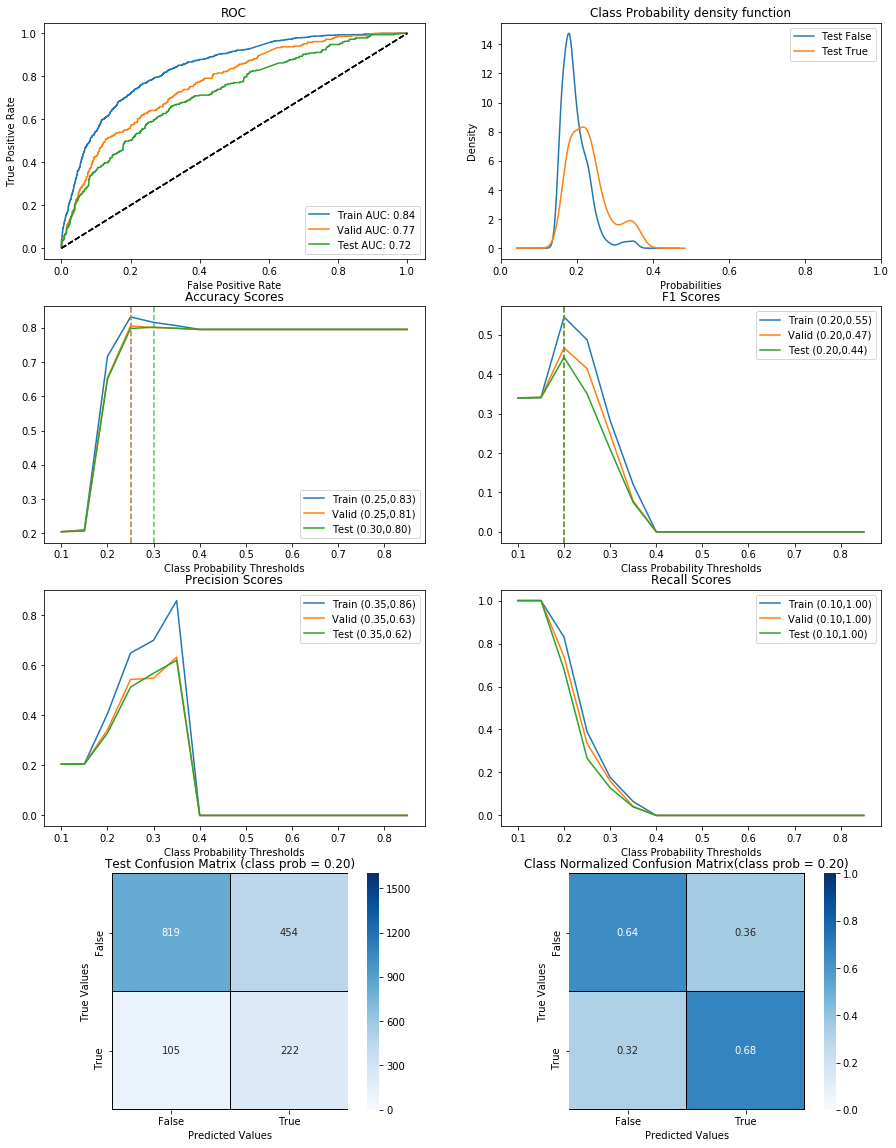

In [55]:
# Grafico de Metricas de resultados
mod_key= 'mod_11'
confusion_matrix_pc = 0.2
temp_dict = result_dict[mod_key]


sets_list = [("Train",y_train,temp_dict["y_train_proba"][:,1]),
             ("Valid",y_valid,temp_dict["y_valid_proba"][:,1]),
             ("Test",y_test,temp_dict["y_test_proba"][:,1]),
            ]    
    
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(nrows=4,ncols=2,figsize=(15,20))    
plot_roc_auc(sets_list,title="ROC", ax= ax1)

#Solo muestro la distribucion de la clase en el set de Test, notar que le paso una lista con un solo elemento
plot_prob_density([sets_list[-1]], ax=ax2)

plot_score_progession(sets_list,eval_func=accuracy_score, title="Accuracy Scores", ax=ax3)
plot_score_progession(sets_list,eval_func=f1_score, title="F1 Scores", ax=ax4)
plot_score_progession(sets_list,eval_func=precision_score, title="Precision Scores", ax=ax5, plot_pc=False)
plot_score_progession(sets_list,eval_func=recall_score, title="Recall Scores", ax=ax6,plot_pc=False)

#solo ploteo la matriz de confusion de de set de test, notar que la entrada toma predicciones ya cortadas con un pc, eneste caso 0.2
plot_confusion_matrix(y_test,temp_dict["y_test_proba"][:,1]>=confusion_matrix_pc, normalize=False, ax=ax7, title="Test Confusion Matrix (class prob = %.2f)"%(confusion_matrix_pc))
plot_confusion_matrix(y_test,temp_dict["y_test_proba"][:,1]>=confusion_matrix_pc, normalize=True, ax=ax8, title="Class Normalized Confusion Matrix(class prob = %.2f)"%(confusion_matrix_pc))

fig.savefig("./resultados/%s_plots.png"%(mod_key), dpi=200)

### Mod_22 

C:\Users\juan.roman\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\juan.roman\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


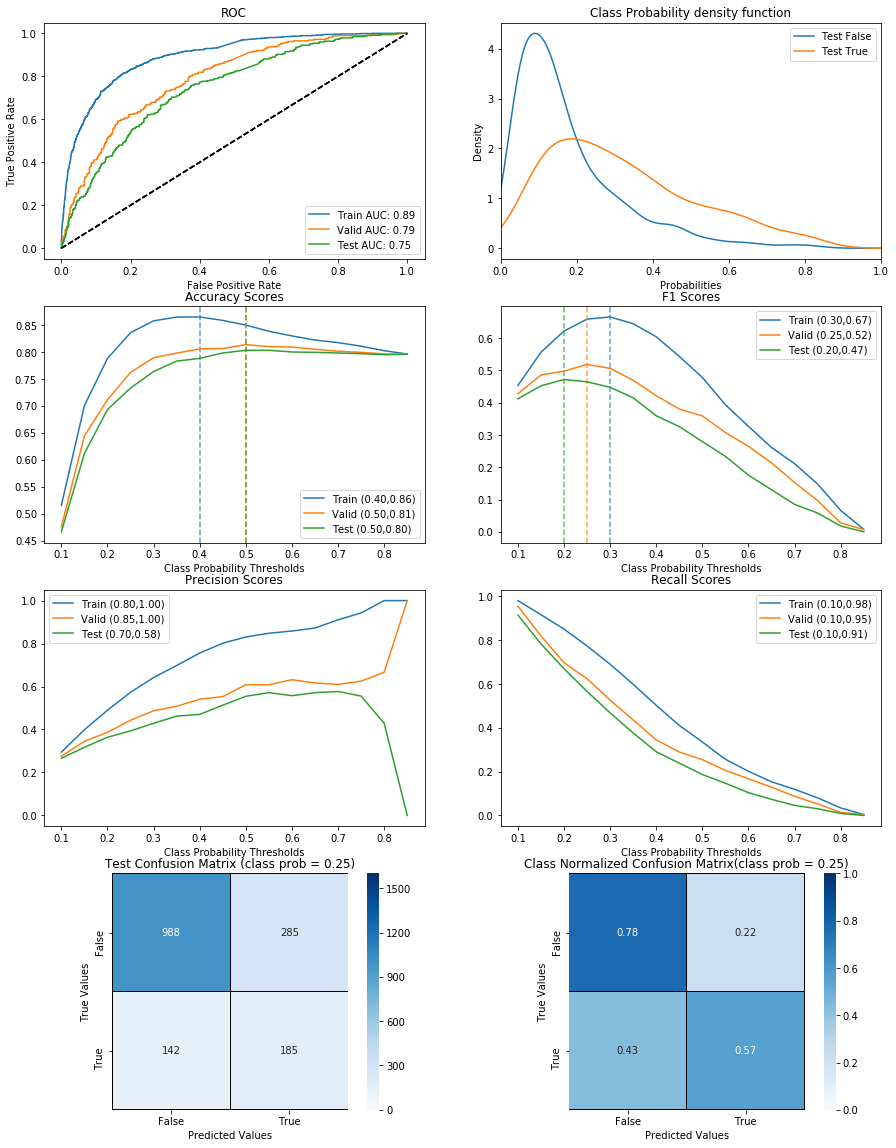

In [56]:
# Grafico de Metricas de resultados
mod_key= 'mod_22'
confusion_matrix_pc = 0.25
temp_dict = result_dict[mod_key]


sets_list = [("Train",y_train,temp_dict["y_train_proba"][:,1]),
             ("Valid",y_valid,temp_dict["y_valid_proba"][:,1]),
             ("Test",y_test,temp_dict["y_test_proba"][:,1]),
            ]    
    
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(nrows=4,ncols=2,figsize=(15,20))    
plot_roc_auc(sets_list,title="ROC", ax= ax1)

#Solo muestro la distribucion de la clase en el set de Test, notar que le paso una lista con un solo elemento
plot_prob_density([sets_list[-1]], ax=ax2)

plot_score_progession(sets_list,eval_func=accuracy_score, title="Accuracy Scores", ax=ax3)
plot_score_progession(sets_list,eval_func=f1_score, title="F1 Scores", ax=ax4)
plot_score_progession(sets_list,eval_func=precision_score, title="Precision Scores", ax=ax5, plot_pc=False)
plot_score_progession(sets_list,eval_func=recall_score, title="Recall Scores", ax=ax6,plot_pc=False)

#solo ploteo la matriz de confusion de de set de test, notar que la entrada toma predicciones ya cortadas con un pc, eneste caso 0.2
plot_confusion_matrix(y_test,temp_dict["y_test_proba"][:,1]>=confusion_matrix_pc, normalize=False, ax=ax7, title="Test Confusion Matrix (class prob = %.2f)"%(confusion_matrix_pc))
plot_confusion_matrix(y_test,temp_dict["y_test_proba"][:,1]>=confusion_matrix_pc, normalize=True, ax=ax8, title="Class Normalized Confusion Matrix(class prob = %.2f)"%(confusion_matrix_pc))

fig.savefig("./resultados/%s_plots.png"%(mod_key), dpi=200)

### Mod_33 

C:\Users\juan.roman\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\juan.roman\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


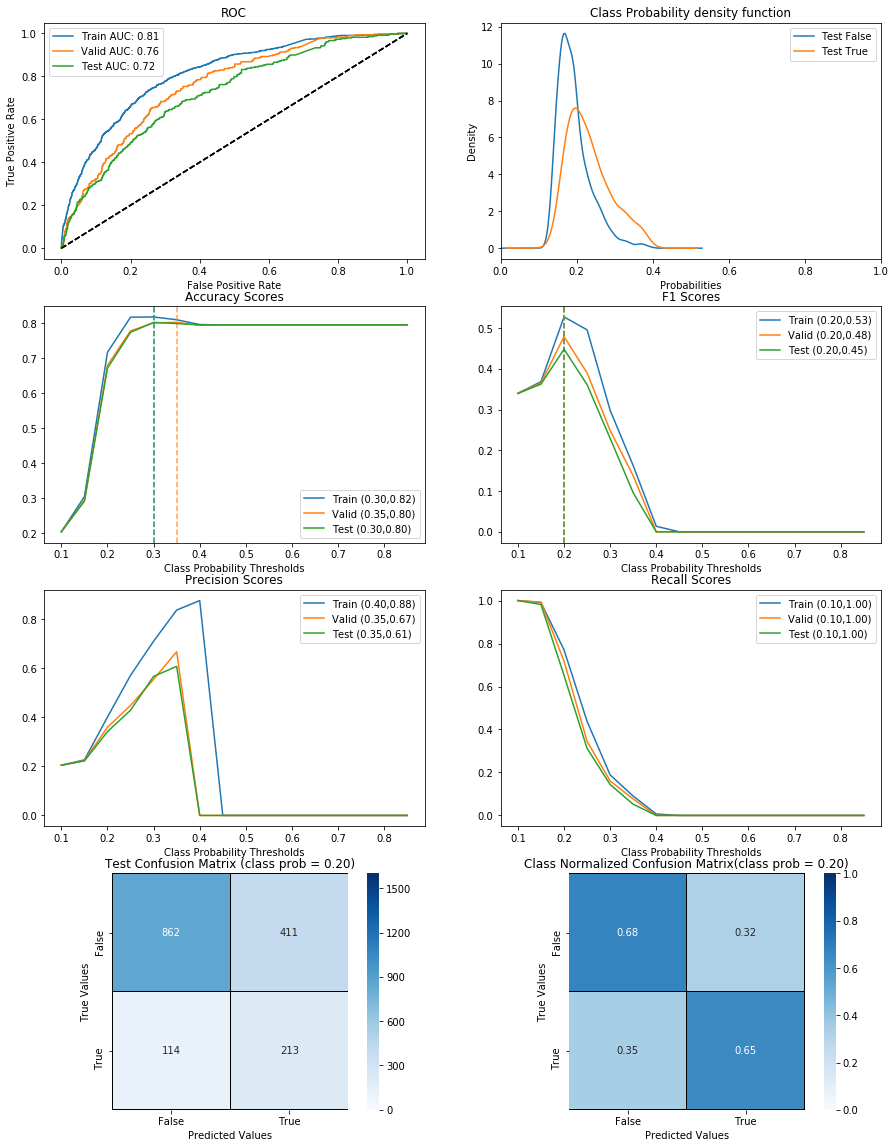

In [57]:
# Grafico de Metricas de resultados
mod_key= 'mod_33'
confusion_matrix_pc = 0.2
temp_dict = result_dict[mod_key]


sets_list = [("Train",y_train,temp_dict["y_train_proba"][:,1]),
             ("Valid",y_valid,temp_dict["y_valid_proba"][:,1]),
             ("Test",y_test,temp_dict["y_test_proba"][:,1]),
            ]    
    
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(nrows=4,ncols=2,figsize=(15,20))    
plot_roc_auc(sets_list,title="ROC", ax= ax1)

#Solo muestro la distribucion de la clase en el set de Test, notar que le paso una lista con un solo elemento
plot_prob_density([sets_list[-1]], ax=ax2)

plot_score_progession(sets_list,eval_func=accuracy_score, title="Accuracy Scores", ax=ax3)
plot_score_progession(sets_list,eval_func=f1_score, title="F1 Scores", ax=ax4)
plot_score_progession(sets_list,eval_func=precision_score, title="Precision Scores", ax=ax5, plot_pc=False)
plot_score_progession(sets_list,eval_func=recall_score, title="Recall Scores", ax=ax6,plot_pc=False)

#solo ploteo la matriz de confusion de de set de test, notar que la entrada toma predicciones ya cortadas con un pc, eneste caso 0.2
plot_confusion_matrix(y_test,temp_dict["y_test_proba"][:,1]>=confusion_matrix_pc, normalize=False, ax=ax7, title="Test Confusion Matrix (class prob = %.2f)"%(confusion_matrix_pc))
plot_confusion_matrix(y_test,temp_dict["y_test_proba"][:,1]>=confusion_matrix_pc, normalize=True, ax=ax8, title="Class Normalized Confusion Matrix(class prob = %.2f)"%(confusion_matrix_pc))

fig.savefig("./resultados/%s_plots.png"%(mod_key), dpi=200)

### Mod_36 

C:\Users\juan.roman\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\juan.roman\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


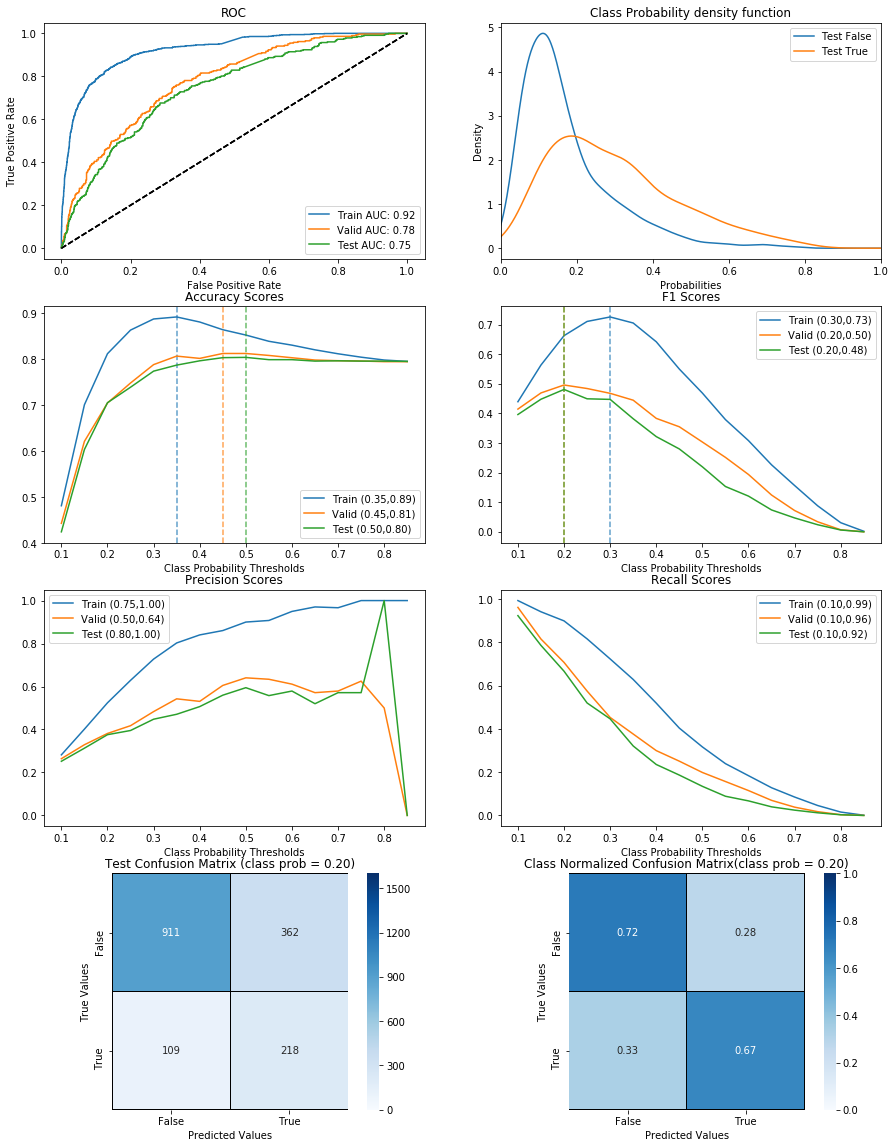

In [58]:
# Grafico de Metricas de resultados
mod_key= 'mod_36'
confusion_matrix_pc = 0.2
temp_dict = result_dict[mod_key]


sets_list = [("Train",y_train,temp_dict["y_train_proba"][:,1]),
             ("Valid",y_valid,temp_dict["y_valid_proba"][:,1]),
             ("Test",y_test,temp_dict["y_test_proba"][:,1]),
            ]    
    
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(nrows=4,ncols=2,figsize=(15,20))    
plot_roc_auc(sets_list,title="ROC", ax= ax1)

#Solo muestro la distribucion de la clase en el set de Test, notar que le paso una lista con un solo elemento
plot_prob_density([sets_list[-1]], ax=ax2)

plot_score_progession(sets_list,eval_func=accuracy_score, title="Accuracy Scores", ax=ax3)
plot_score_progession(sets_list,eval_func=f1_score, title="F1 Scores", ax=ax4)
plot_score_progession(sets_list,eval_func=precision_score, title="Precision Scores", ax=ax5, plot_pc=False)
plot_score_progession(sets_list,eval_func=recall_score, title="Recall Scores", ax=ax6,plot_pc=False)

#solo ploteo la matriz de confusion de de set de test, notar que la entrada toma predicciones ya cortadas con un pc, eneste caso 0.2
plot_confusion_matrix(y_test,temp_dict["y_test_proba"][:,1]>=confusion_matrix_pc, normalize=False, ax=ax7, title="Test Confusion Matrix (class prob = %.2f)"%(confusion_matrix_pc))
plot_confusion_matrix(y_test,temp_dict["y_test_proba"][:,1]>=confusion_matrix_pc, normalize=True, ax=ax8, title="Class Normalized Confusion Matrix(class prob = %.2f)"%(confusion_matrix_pc))

fig.savefig("./resultados/%s_plots.png"%(mod_key), dpi=200)

### ----------------------------------------------------------------------------------------
## COMPARACION DE MODELOS
Las funciones de graficos pueden utilizarse para comparar modelos 


C:\Users\juan.roman\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\juan.roman\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


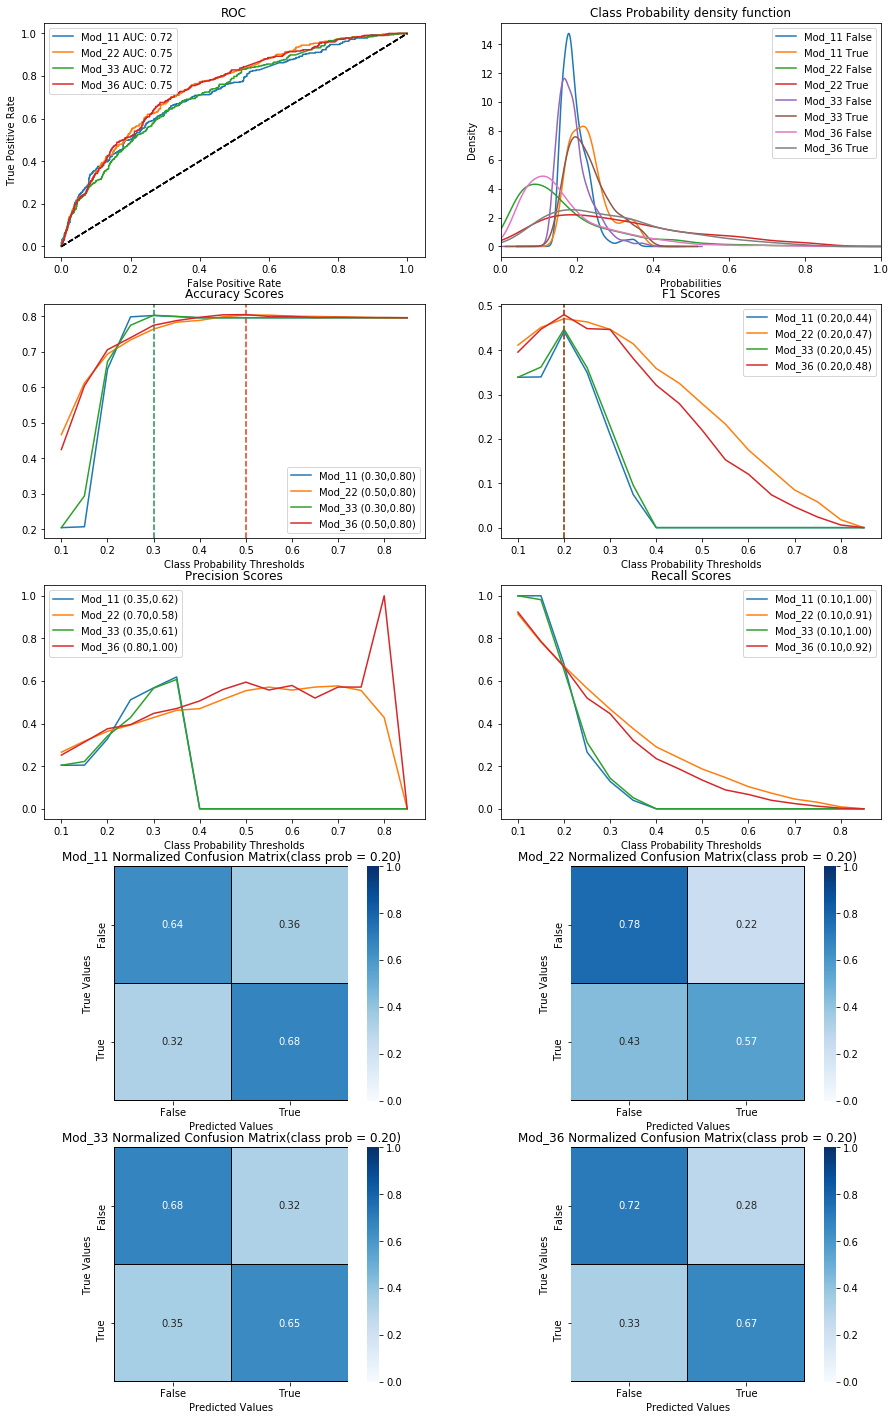

In [63]:
# Grafico de Metricas de resultados
mod_key= 'mod_36'
confusion_matrix_pc = 0.2
temp_dict = result_dict[mod_key]


sets_list = [("Mod_11",y_test,result_dict["mod_11"]["y_test_proba"][:,1]),
             ("Mod_22",y_test,result_dict["mod_22"]["y_test_proba"][:,1]),
             ("Mod_33",y_test,result_dict["mod_33"]["y_test_proba"][:,1]),
             ("Mod_36",y_test,result_dict["mod_36"]["y_test_proba"][:,1]),
            ]    
    
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10)) = plt.subplots(nrows=5,ncols=2,figsize=(15,25))    
plot_roc_auc(sets_list,title="ROC", ax= ax1)

#Solo muestro la distribucion de la clase en el set de Test, notar que le paso una lista con un solo elemento
plot_prob_density(sets_list, ax=ax2)

plot_score_progession(sets_list,eval_func=accuracy_score, title="Accuracy Scores", ax=ax3)
plot_score_progession(sets_list,eval_func=f1_score, title="F1 Scores", ax=ax4)
plot_score_progession(sets_list,eval_func=precision_score, title="Precision Scores", ax=ax5, plot_pc=False)
plot_score_progession(sets_list,eval_func=recall_score, title="Recall Scores", ax=ax6,plot_pc=False)

#solo ploteo la matriz de confusion de de set de test, notar que la entrada toma predicciones ya cortadas con un pc, eneste caso 0.2
plot_confusion_matrix(y_test,result_dict["mod_11"]["y_test_proba"][:,1]>=0.2, normalize=True, ax=ax7, title="%s Normalized Confusion Matrix(class prob = %.2f)"%("Mod_11",confusion_matrix_pc))
plot_confusion_matrix(y_test,result_dict["mod_22"]["y_test_proba"][:,1]>=0.25, normalize=True, ax=ax8, title="%s Normalized Confusion Matrix(class prob = %.2f)"%("Mod_22",confusion_matrix_pc))
plot_confusion_matrix(y_test,result_dict["mod_33"]["y_test_proba"][:,1]>=0.2, normalize=True, ax=ax9, title="%s Normalized Confusion Matrix(class prob = %.2f)"%("Mod_33",confusion_matrix_pc))
plot_confusion_matrix(y_test,result_dict["mod_36"]["y_test_proba"][:,1]>=0.2, normalize=True, ax=ax10, title="%s Normalized Confusion Matrix(class prob = %.2f)"%("Mod_36",confusion_matrix_pc))

fig.savefig("./resultados/Comparacion_plots.png", dpi=200)

### Importancia de variables 

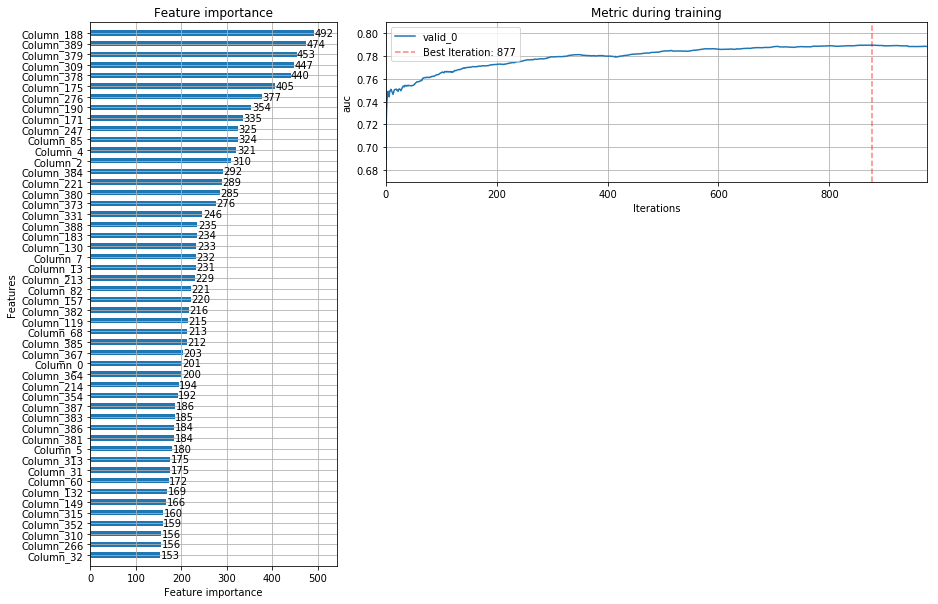

In [80]:
### Grafico del modelo, solo aplica la LIGTHGBM
from matplotlib.gridspec import GridSpec
mod_key = "mod_22"
clf = result_dict[mod_key]["clf_fitted"]

fig = plt.figure(figsize=(15,10))
gs = GridSpec(3, 3)

ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[0,1:3])

lgb.plot_importance(clf,max_num_features=50,height=0.5,ax= ax1 )
lgb.plot_metric(clf, ax= ax2 )

ax2.axvline(clf.best_iteration_, linestyle="--", c="r", alpha=0.5, label="Best Iteration: %d"%(clf.best_iteration_))
ax2.legend()
#_= fig.suptitle("%s"%mod_key)

#fig.tight_layout()
fig.savefig("%s_feature_importance.png"%(mod_key),dpi=200)